In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [4]:
words = open('names.txt', 'r').read().splitlines()

# Lecture 2

## Bigram probability approach

Creating bigrams - two letter objects capturing what letter is likely to follow another
adding a start and an end characters to capture what letter to start with and with which letter the word is likely to end the word

In [111]:
b={}
for w in words[:1]:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs,chs[:1]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) +1 # counting the number that a bigram occurs


storing the bigram information in a 2D array (pytorch tensors) where the rows are the first character and the columns are the second character

In [112]:
import torch

In [113]:
N = torch.zeros((27,27), dtype=torch.int32)

chars = sorted(list(set(''.join(words ))))
stoi = {s:i+1 for i,s in enumerate(chars)} #mapping of a character to an index
stoi['.'] = 0 # replacing special end and start characters with a single . representing the space between words
itos = {i:s for s,i in stoi.items()}
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs,chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2] # index of the character - defining position in the array
        N[ix1,ix2] += 1

In [114]:
P = (N+1).float() #convert to float cause we want to devide
#(N+1) is model smoothing give all possible bigrams at least 1 count removing infinities in log_likelyhood
P /= P.sum(1, keepdim=True) # normalize occurences , in-place operation has potential to be faster - doesnt create more memory under-the-hood


In [115]:
g = torch.Generator().manual_seed(2147484647)
for i in range(20):
    ix = 0
    out=[]
    while True:
        p=P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item() #obtianing normal distribuition from probabilities 
        out.append(itos[ix])
        if ix ==0:
            break
    print(''.join(out))

nieran.
cele.
brolyah.
ananei.
egin.
baijeriesetengh.
bebynnojarzakia.
h.
n.
er.
xlah.
assaiavees.
be.
drikyly.
en.
d.
an.
ja.
ma.
am.


when printing the probabilities of bigrams in real words we want the total probability according to a well trained model to be close to 1 (maximize the likelyhood). we can use log(likelyhood) for convenience - total prob = product of all probabilities which will be a tiny number for many words - log_likelyhood is a more natural number. 
negative log likelyhood - good loss function minimum is 0. use the average -.

In [116]:
log_likelyhood = 0.0
n=0
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs,chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2] 
        prob = P[ix1,ix2]
        log_likelyhood += torch.log(prob)
        n+=1
nll = -log_likelyhood
print(f'{nll/n}')


2.4543561935424805


## Neural network approach

creating training set

In [117]:
import torch
N = torch.zeros((27,27), dtype=torch.int32)

chars = sorted(list(set(''.join(words ))))
stoi = {s:i+1 for i,s in enumerate(chars)} #mapping of a character to an index
stoi['.'] = 0 # replacing special end and start characters with a single . representing the space between words
itos = {i:s for s,i in stoi.items()}

In [118]:
xs, ys = [],[]
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs,chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2] # index of the character - defining position in the array
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs) # input
ys = torch.tensor(ys) # output - second letter
num = xs.nelement()


right now, xs and ys are tensors of integer index values 0-27. these cant be used as input for NN - use one-hot encoding

In [119]:
import torch.nn.functional as F
W = torch.randn((27,27), requires_grad=True) #random weights - makes 27 neurons, after multiplying with xsoh
W.shape

torch.Size([27, 27])

In [120]:
xsoh = F.one_hot(xs, num_classes=27).float()
xsoh.shape

torch.Size([228146, 27])

gradient descent

In [ ]:
for n in range(10):
#forward pass    
    xsoh = F.one_hot(xs, num_classes=27).float()
    logits = xsoh @ W #matrix multiplication - activation of the weights at the positions of xs, equivalent to log-counts
    count = logits.exp() # exponantiate the tensor element-wise giving an positive value for all, eqiuvalent to count
    prob = count / count.sum(1, keepdim=True) # normalize - SOFTMAX
    #prob[0] will give a vector of probabilities representing what is likely to follow the first letter
    #all operations are easily differentaible so also backpropagable 
    loss = -prob[torch.arange(num), ys].log().mean() #average nll used as loss, taking the probabilities of the next letter at the correct indecies for which we are training. When we input a word which we want to use as training data, the probabilities of interest are of characters within the word - these train the weights associated with the word
    print(loss.item())

#backward pass
    W.grad = None
    loss.backward() 

#update

    W.data += -10 * W.grad


E01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?
E02: split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?
E03: use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?
E04: we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?
E05: look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?
E06: meta-exercise! Think of a fun/interesting exercise and complete it.

## Trigram model


In [124]:
xs1, xs2, ys = [],[], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs,chs[1:],chs[2:]):
        ix1 = stoi[ch1] # index of the character - defining position in the array
        ix2 = stoi[ch2] 
        ix3 = stoi[ch3]
        # Do I need to stop here if ix3 == 0? Does zip remove rows where entries are empty?
        xs1.append(ix1)
        xs2.append(ix2)
        ys.append(ix3)


xs1 = torch.tensor(xs1) # input
xs2 = torch.tensor(xs2) # input
xs = torch.stack((xs1, xs2), dim=1)
ys = torch.tensor(ys) # output - third letter
num = xs.nelement()
num = int(num/2)

In [125]:
import torch.nn.functional as F
W = torch.randn((27,27,27), requires_grad=True) #random weights - makes 27 neurons, after multiplying with xsoh

# Convert (row, col) to a single index in a flattened 27x27 matrix
flat_index = xs[:, 0] * 27 + xs[:, 1]

# One-hot encode in a flattened space
one_hot_flat = F.one_hot(flat_index, num_classes=27 * 27)

# Reshape back to 27x27
one_hot_matrix = one_hot_flat.view(len(xs),27, 27).float()

In [134]:
for n in range(300):
#forward pass    
    logits = torch.einsum('bij,ijk->bk', one_hot_matrix, W) #matrix multiplication - activation of the weights at the positions of xs, equivalent to log-counts
    count = logits.exp() # exponantiate the tensor element-wise giving an positive value for all, eqiuvalent to count
    prob = count / count.sum(1, keepdim=True) # normalize - SOFTMAX
    #prob[0] will give a vector of probabilities representing what letter is likely to follow the first letter
    #all operations are easily differentaible so also backpropagable 
    loss = -prob[torch.arange(num), ys].log().mean() #average negative log likelyhood used as loss, taking the probabilities of the next letter at the correct indecies for which we are training. When we input a word which we want to use as training data, the probabilities of interest are of characters within the word - these train the weights associated with the word
    print(loss.item())

#backward pass
    W.grad = None
    loss.backward() 

#update

    W.data += -10 * W.grad


2.39247727394104
2.3920223712921143
2.391569137573242
2.3911173343658447
2.3906667232513428
2.3902175426483154
2.3897695541381836
2.3893229961395264
2.3888776302337646
2.3884339332580566
2.387991189956665
2.387550115585327
2.3871099948883057
2.386671543121338
2.3862340450286865
2.3857979774475098
2.3853628635406494
2.384929656982422
2.3844974040985107
2.384066343307495
2.383636474609375
2.3832080364227295
2.3827807903289795
2.382354736328125
2.381930112838745
2.3815064430236816
2.3810842037200928
2.3806631565093994
2.3802430629730225
2.379824638366699
2.3794071674346924
2.378990888595581
2.3785758018493652
2.378161668777466
2.377748966217041
2.3773372173309326
2.376926898956299
2.3765175342559814
2.3761096000671387
2.3757026195526123
2.3752965927124023
2.374892234802246
2.374488592147827
2.374086380004883
2.373685121536255
2.3732848167419434
2.3728857040405273
2.372487783432007
2.372091054916382
2.3716952800750732
2.37130069732666
2.3709070682525635
2.3705146312713623
2.370123386383056

In [158]:
g = torch.Generator()#.manual_seed(2147484647)
for i in range(20):
    douplex = torch.tensor([[0,0]])
    ix=0
    out=[]
    while True:
        one_hot_matrix = F.one_hot(douplex[-1, 0] * 27 + douplex[-1, 1], num_classes=27 * 27).view(1,27, 27).float()
        logits = torch.einsum('bij,ijk->bk', one_hot_matrix, W) 
        count = logits.exp()
        prob = count / count.sum(1, keepdim=True)
        ix = torch.multinomial(prob, num_samples=1, replacement=True, generator=g).item() #obtianing normal distribuition from probabilities 
        douplex[0, 0]=douplex[0, 1]
        douplex[0, 1]=ix
        #douplex.append(douplex[-1, :])
        out.append(itos[ix])
        if ix ==0:
            break
    print(''.join(out))

trionniwhskvglmagp.
wxfjlanda.
velie.
brbaqptjevertumivqehyanna.
bpzerey.
te.
cogzyla.
zgcffnzjdkxarionwatvcbkbnwlqvpazaudmmrtnd.
ami.
fart.
halrkdenianean.
vayn.
ya.
gophmyhuziyluoe.
essibxyden.
za.
chennafx.
tyor.
ton.
upuoeigh.


# Lecture 3: MLP Approach

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)} #mapping of a character to an index
stoi['.'] = 0 # replacing special end and start characters with a single . representing the space between words
itos = {i:s for s,i in stoi.items()}

Multi-character dataset

In [ ]:
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [],[]

for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X. append (context)
        Y.append (ix) 
        context = context [1:] + [ix] # crop and append
        
X = torch.tensor(X) #X is defined as a 3 characters long tensor
Y = torch.tensor(Y)

Embedding of the characters (all 27) into a 2D space. Each character will be represented by a vector in this 2D space. At the beginning this vector is random.

In [102]:
C = torch.randn((27,2)) #random matrix
emb = C[X] #awsome torch indexing, each letter of each X will be indexed to the correct row of C

#create hidden layer
W1 = torch.randn((6,100)) #input are three 2D tensors, which we concatenate to 6, the size of the hidden layer is taken to be 100
b1 = torch.randn(100) #size of hidden layer
h = torch.tanh(emb.view(-1,6) @ W1 + b1) #.view reshapes the tensor without creating additional memory


#create output layer
W2 = torch.randn((100,27))
b2 = torch.randn(27)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [ ]:
explenations
#Forward pass
logits = h @ W2 + b2
#counts = logits.exp()
#prob = counts/counts.sum(1, keepdims=True)
#oss = -prob[torch.arange(len(X)),Y].log().mean()
#more efficient classification using cross_entropy
loss = F.cross_entropy(logits, Y) #avoids creating many tensors (fused kernel)=less memory, faster backprop - mathematically derived derivative can take a simpler analytical form
                            #numerically better behaved for large positive numbers - subtracts largest number prior to normalization

#backward pass
for p in parameters:
    p.grad = None
loss.backward()

#update
for p in parameters:
    p.data += -0.1 *p.grad

In [ ]:
for _ in range(10):
    emb = C[X]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())

    for p in parameters:
        p.grad = None
    loss.backward()

    for p in parameters:
        p.data += -0.1 *p.grad

Training on a whole dataset is expensive, create a random small batch which will provide an approximate gradient. Quality of gradient is lower-direction of gradient descend isnt optimal, but we can do many more optimization steps. It is more efficient to perform many steps over non-ideal direction compared to few steps in the perfect direction. 

In [ ]:
for _ in range(1000):

    #minibatch
    ix = torch.randint(0,X.shape[0],(32,))

    emb = C[X[ix]] #only getting 32 rows of X

    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())

    for p in parameters:
        p.grad = None
    loss.backward()

    for p in parameters:
        p.data += -0.1 *p.grad

In [53]:
# loss on the entire dataset
emb = C[X] #only getting 32 rows of X

h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.7360, grad_fn=<NllLossBackward0>)

To find the optimum learning rate, first look for the range, max LR before it explodes and min LR which actually loweres loss.
do exponential linspace of the range
do the same number of optim steps as the size of linspace and vary LR each iteration
print loss over lr

In [78]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

In [ ]:
lri = []
lossi = []

for i in range(1000):

    #minibatch
    ix = torch.randint(0,X.shape[0],(32,)) # new minibatch for each iteration

    emb = C[X[ix]] #only getting 32 rows of X

    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = lrs[i]

    for p in parameters:
        p.data += -lr *p.grad
    lri.append(lre[i])
    lossi.append(loss.item())

17.37198257446289
tensor(0.0010)
17.597599029541016
tensor(0.0010)
15.2627592086792
tensor(0.0010)
18.075775146484375
tensor(0.0010)
16.445819854736328
tensor(0.0010)
14.616150856018066
tensor(0.0010)
16.729692459106445
tensor(0.0010)
19.397321701049805
tensor(0.0010)
15.906865119934082
tensor(0.0011)
17.100263595581055
tensor(0.0011)
17.05754280090332
tensor(0.0011)
19.334293365478516
tensor(0.0011)
15.03417682647705
tensor(0.0011)
16.81635093688965
tensor(0.0011)
14.145261764526367
tensor(0.0011)
17.405447006225586
tensor(0.0011)
18.64630126953125
tensor(0.0011)
17.36163902282715
tensor(0.0011)
16.761648178100586
tensor(0.0011)
15.382832527160645
tensor(0.0011)
16.934467315673828
tensor(0.0011)
15.871088981628418
tensor(0.0012)
17.573793411254883
tensor(0.0012)
17.87126922607422
tensor(0.0012)
17.396089553833008
tensor(0.0012)
18.290990829467773
tensor(0.0012)
18.213151931762695
tensor(0.0012)
17.199207305908203
tensor(0.0012)
16.425193786621094
tensor(0.0012)
17.27492332458496
tenso

Text(0.5, 1.0, 'Rough estimate of best LR')

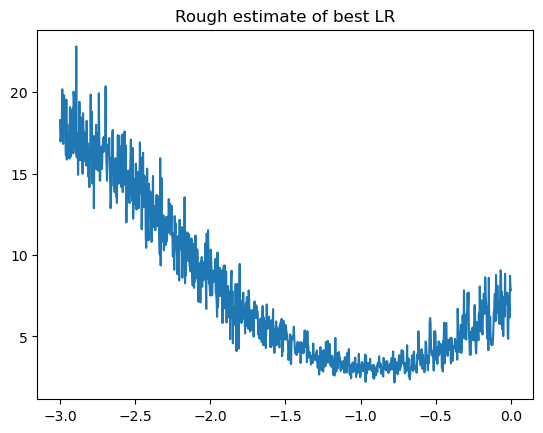

In [80]:
plt.plot(lri, lossi)
plt.title('Rough estimate of best LR')

In [120]:
for i in range(1000):

    #minibatch
    ix = torch.randint(0,X.shape[0],(128,))

    emb = C[X[ix]] #only getting 32 rows of X

    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    #print(loss.item())

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.01
    for p in parameters:
        p.data += -lr *p.grad


splitting the data to dev,test and training sets
training - 80% for fitting
dev - 10% for hyperparam tuning
test - 10% evaluate performance 

In [ ]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out=[]
    context = [0] * block_size # initialize with all ...

    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        if ix == 0: 
            break
    print(''.join(itos[i] for i in out) ) 

# Lecture 4: MLP continued

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)} #mapping of a character to an index
stoi['.'] = 0 # replacing special end and start characters with a single . representing the space between words
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
def build_dataset (words) :
    X, Y = [],[]
    for w in words:
        context = [0] * block_size
        for ch in w+ '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    X = torch. tensor (X)
    Y = torch. tensor (Y)
    print(X. shape, Y.shape)
    return X, Y

import random 
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words) )
n2 = int (0.9*len(words) )
Xtr, Ytr = build_dataset (words[:n1])
Xdev, Ydev = build_dataset (words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## Fixing saturated Tanh by hand and Kaiming initialization

In [9]:
# flexible MLP 
n_emb = 10
n_hidden = 200

C = torch.randn((vocab_size,n_emb)) 

W1 = torch.randn((n_emb*block_size,n_hidden)) 
b1 = torch.randn(n_hidden)

W2 = torch.randn((n_hidden,vocab_size))
b2 = torch.randn(vocab_size)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print(sum(p.nelement() for p in parameters))

11897


In [ ]:
#optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch
    ix = torch.randint(0,Xtr.shape[0],(batch_size,)) # new minibatch for each iteration
    Xb, Yb = Xtr[ix], Ytr[ix]
    emb = C[Xb] #embed characters into vectors
    embcat = emb.view(emb.shape[0],-1) #concatenate vectors 

    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    

    for p in parameters:
        p.grad = None
    loss.backward()

    #lr = lrs[i]
    lr = 0.1 if i<10000 else 0.01
    for p in parameters:
        p.data += -lr *p.grad

    lossi.append(loss.log10().item())

    if i % 10000 == 0:
        print(loss.item())

32.27058410644531
2.473325729370117
2.4904024600982666
2.2260236740112305
2.711437463760376
2.001110792160034
2.3915982246398926
2.2679760456085205
2.4073357582092285
2.2990217208862305
2.1030995845794678
2.4831175804138184
1.9825557470321655
2.460059881210327
2.006160259246826
2.412266731262207
2.2091636657714844
1.9615557193756104
2.4291155338287354
2.250331163406372


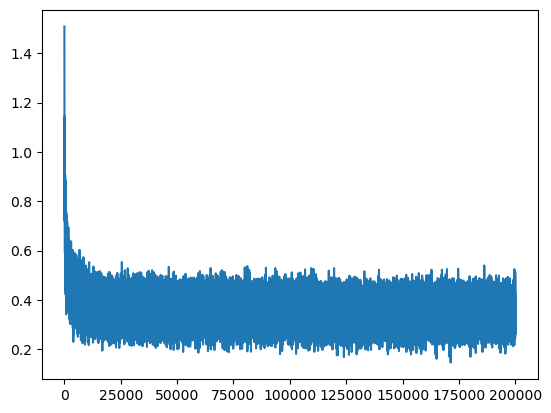

In [12]:
plt.plot(torch.arange(max_steps), lossi)

In [ ]:
@torch.no_grad() #decorator to disable gradient tracking. Saves memory when only the weights of the final model are needed, no training on test and dev
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('test')

train 2.2536935806274414
test 2.279484272003174


In [17]:
# sample the model
g= torch.Generator()

for _ in range(20):
    out = []
    context = [0]*block_size
    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view(1, -1)
        h = torch.tanh(embcat @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

kodolaila.
tora.
alvania.
jalon.
helie.
nivabetiel.
walliver.
yadamis.
zeto.
azely.
greya.
zicf.
nuvikrestona.
aveeth.
wlyn.
azedel.
blay.
ami.
fart.
halre.


### At initialization of the training, we would expect the model to predict any letter with equal probability for each case. 
The resulting loss (nll) of such an equal opportunity model is -torch.tensor(1/27.0).log()=3.2958 - thats much lower than a model with random weights, the NN is confident in the wrong predictions

### Problem of tanh activation function

if pretanh = embcat @ W1 + b1 and h = torch.tanh(pretanh)

and pretanh has a very broad distribution

then a lot of neurons h will have values close to -1 or 1, on the tails of tanh, where gradient is close to 0. During backprop, the gradiets get destroyed at tanh and the neuron doesnt learn from that example. If a neuron has tanh value close to zero for all examples that are passed to it, its called a Dead Neuron, it never learns. 

neurons can "die" at activation due to randomly assigning weights or during optimization if the LR is too large the value of the weight can get knocked-out into the dead region. 

ReLu also suffers from it but Leaky ReLu (or ELU) overcomes the issue.

to make the pretanh distribution less broad, multiply W1 and b1 by a number < 1

general rules for setting the scales of weights - no magic numbers

-scale W to keep normal distribution
The scaling is dependant on the non-linearity function, for tanh its 1/√fan-in for ReLu its 2/√fan-in
-in production activation is done with torch.nn.init.kaiming_normal_()

The careful choice of activation has become less importent due to better optimization procedures (eg Adam), batch normalizations and residual connection

tensor(-0.0096) tensor(0.9941)
tensor(-0.0054) tensor(3.1309)


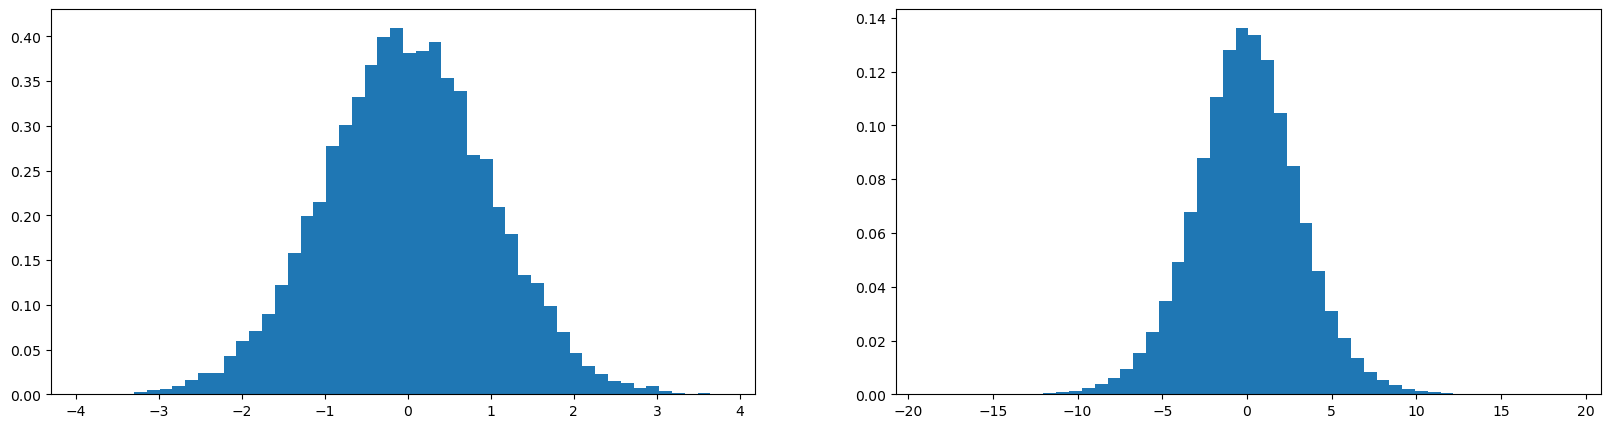

In [ ]:
x = torch.randn(1000, 10) # normal distribution
w = torch.randn(10, 200) / 10**0.5 # devide by squareroot of 
y = x@w # Gaussian with larger std if w is not scaled
print(x.mean(),x.std())
print(y.mean(),y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [ ]:
# flexible MLP 
n_emb = 10
n_hidden = 200

C = torch.randn((vocab_size,n_emb)) 

W1 = torch.randn((n_emb*block_size,n_hidden)) * (5/3)/(n_emb*block_size)**0.5 # kaiming init makes the distribution of weights less wide
b1 = torch.randn(n_hidden) * 0.01

# if W2 is all 0 shit can go worng, 0.01 breaks symmetry 
W2 = torch.randn((n_hidden,vocab_size)) * 0.01 # making the weights much closer to 0 - NN is "less confidant" 
b2 = torch.randn(vocab_size) * 0 # no bias at the beginning

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print(sum(p.nelement() for p in parameters))

11897


In [ ]:
#optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch
    ix = torch.randint(0,Xtr.shape[0],(batch_size,)) # new minibatch for each iteration
    Xb, Yb = Xtr[ix], Ytr[ix]
    emb = C[Xb] #embed characters into vectors
    embcat = emb.view(emb.shape[0],-1) #concatenate vectors 

    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    

    for p in parameters:
        p.grad = None
    loss.backward()

    #lr = lrs[i]
    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr *p.grad

    lossi.append(loss.log10().item())

    if i % 10000 == 0:
        print(loss.item())


In [38]:
#making the weights smaller made the traing achieve lower scores in the same amount of iterations
# in large NNs mistakes like this could not only hinder training but even make it impossible 
split_loss('train')
split_loss('test')

train 2.039172887802124
test 2.105219602584839


## Batch Normalization

For normalization of pre-activation states

In [19]:
# flexible MLP 
n_emb = 10
n_hidden = 200

C = torch.randn((vocab_size,n_emb)) 

W1 = torch.randn((n_emb*block_size,n_hidden)) * (5/3)/(n_emb*block_size)**0.5 
# since we are subtracting the mean in each batch the bias gets cancelled out
#bnbias takes its
#b1 = torch.randn(n_hidden) * 0.01 


W2 = torch.randn((n_hidden,vocab_size)) * 0.01 
b2 = torch.randn(vocab_size) * 0 

# parameters for the batch normalization
# at initialization all neurons will be exactly unit gaussian 
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.ones((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]

for p in parameters:
    p.requires_grad = True

print(sum(p.nelement() for p in parameters))

12097


In [20]:
#optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch
    ix = torch.randint(0,Xtr.shape[0],(batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    emb = C[Xb] 
    embcat = emb.view(emb.shape[0],-1) 
    pre_act = embcat @ W1 #+ b1  want this to be roughly gaussian, bias gets averaged out


    mean = pre_act.mean(0, keepdim=True) 
    std = pre_act.std(0, keepdim=True)
    #binding the batch examples mathematically like in batch normalization sometimes leads the strange errors and bugs
    pre_act = bngain*(pre_act-mean)/std + bnbias # normalizing wrt this specific batch
    # we want the NN to be able to adjust the shape and location of the distribution
    

    # computes approximation of mean and std for the entire dataset on the fly. no need for calculating it separately
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * mean
        bnstd_running = 0.999 * bnstd_running + 0.001 * std

    h = torch.tanh(pre_act)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    

    for p in parameters:
        p.grad = None
    loss.backward()

    #lr = lrs[i]
    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr *p.grad

    lossi.append(loss.log10().item())

    if i % 10000 == 0:
        print(loss.item())

3.2672667503356934
2.1170761585235596
2.084096670150757
1.9857885837554932
1.8786606788635254
2.1533515453338623
2.152493476867676
2.4236111640930176
2.5141963958740234
2.3796446323394775
2.3899810314178467
2.050898313522339
2.14581036567688
2.1042139530181885
2.291940927505493
1.7776809930801392
2.0073163509368896
2.345715284347534
1.7504675388336182
2.1898441314697266


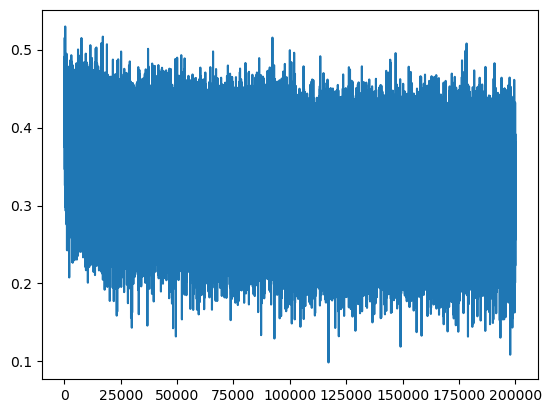

In [21]:
plt.plot(torch.arange(max_steps), lossi)

Calibrating batch normalization at the end of training using the mean and std over the whole data set

this can be replaced by bnmean/bnstd _running which have very similar values

In [22]:
with torch.no_grad():
    # pass the training set through
    emb = C [Xtr]
    embcat = emb. view(emb.shape[0], -1)
    pre_act = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bmean = pre_act.mean(0, keepdim=True)
    bnstd = pre_act.std(0, keepdim=True)

In [23]:
@torch.no_grad() #decorator to disable gradient tracking. Saves memory when only the weights of the final model are needed, no training on test and dev
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    pre_act = embcat @ W1 + b1 
    pre_act = bngain*(pre_act-bnmean_running)/bnstd_running + bnbias 
    h = torch.tanh(pre_act)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('test')

train 2.070183038711548
test 2.112933397293091


## Making code torch-like to make it easier to build a deeper NN

In [ ]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.rand((fan_in,fan_out))/fan_in**0.5 #kammin initualization included
        self.bias = torch.rand(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True # different for training and inferece or testing

        #paramteres of batch training (weigth and bias equivalent)
        self.gamma = torch.ones(dim)
        self.beta =torch.rand(dim)

        #called buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        #forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) #mean and variance of the batch
            xvar = x.std(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x -xmean)/torch.sqrt(xvar + self.eps) # normal distribution
        self.out = self.gamma*xhat+self.beta

        # training buffers using exponential moving average
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, *args, **kwds):
        self.out = torch.tanh(x)
        return self.out 
    def parameter(self):
        return [] #no param in this layer
    

In [ ]:
n_emb = 10 
n_hidden = 100

C = torch.randn((vocab_size, n_emb))
layers = [
    Linear(n_emb*block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), Tanh(),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True

# Lecture 5: WaveNET

In [41]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)} #mapping of a character to an index
stoi['.'] = 0 # replacing special end and start characters with a single . representing the space between words
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [42]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?
def build_dataset (words) :
    X, Y = [],[]
    for w in words:
        context = [0] * block_size
        for ch in w+ '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    X = torch. tensor (X)
    Y = torch. tensor (Y)
    print(X. shape, Y.shape)
    return X, Y

import random 
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words) )
n2 = int (0.9*len(words) )
Xtr, Ytr = build_dataset (words[:n1])
Xdev, Ydev = build_dataset (words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182580, 8]) torch.Size([182580])
torch.Size([22767, 8]) torch.Size([22767])
torch.Size([22799, 8]) torch.Size([22799])


## Making our version of torch.nn simpler to run

In [43]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.rand((fan_in,fan_out))/fan_in**0.5 #kammin initualization included
        self.bias = torch.rand(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True # different for training and inferece or testing

        #paramteres of batch training (weigth and bias equivalent)
        self.gamma = torch.ones(dim)
        self.beta =torch.rand(dim)

        #buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        #forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) #mean and variance of the batch
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean)/torch.sqrt(xvar + self.eps) # normal distribution
        self.out = self.gamma*xhat+self.beta

        # training buffers using exponential moving average
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out 
    def parameters(self):
        return [] #no param in this layer

# look up table from characters to tensors 
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    def parameters(self):
        return [self.weight]

# replaces the reshaping/concatanation of tensors
class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0],-1)
        return self.out
    def parameters(self):
        return []    

# includes list comprehension
class Sequential: 
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def paramaters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    

In [51]:
n_emb = 10 
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_emb),
    Flatten(),
    Linear(n_emb*block_size, n_hidden, bias=False), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1

parameters = model.paramaters()
for p in parameters:
    p.requires_grad = True

In [45]:
#optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch
    ix = torch.randint(0,Xtr.shape[0],(batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    logits = model(Xb)

    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    #lr = lrs[i]
    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr *p.grad

    lossi.append(loss.log10().item())

    if i % 10000 == 0:
        print(loss.item())


3.1595730781555176
1.8208887577056885
2.2347421646118164
2.1342012882232666
2.585350513458252
2.088003635406494
1.45916748046875
1.7483974695205688
2.2185888290405273
1.7794703245162964
1.9658396244049072
2.0274319648742676
2.1975607872009277
1.750413417816162
1.8197529315948486
1.9617787599563599
2.381347179412842
2.001354217529297
2.264439105987549
2.3735594749450684


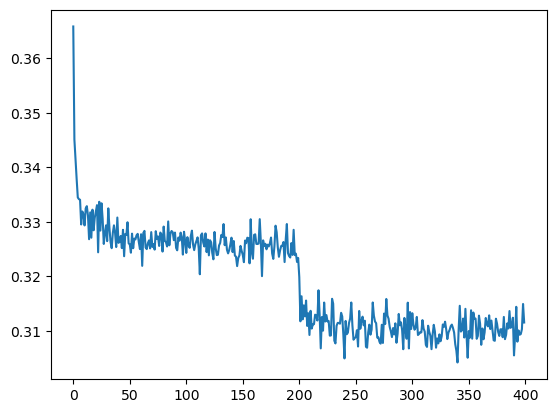

In [46]:
plt.plot(torch.tensor(lossi).view(-1,500).mean(1))

In [47]:
# for evaluation of the NN training of batch layer needs to be turned off
for layer in model.layers:
    layer.training = False

In [48]:
@torch.no_grad() #decorator to disable gradient tracking. Saves memory when only the weights of the final model are needed, no training on test and dev
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]


    logits = model(x)    
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('test')

train 2.0524024963378906
test 2.1100575923919678


In [49]:
g= torch.Generator()

for _ in range(20):
    out = []
    context = [0]*block_size
    while True:
        logits = model(torch.tensor([context])) 

        probs = F.softmax(logits, dim=1)
        
        ix = torch.multinomial(probs, num_samples=1).item()

        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

nity.
den.
asnaeyosseigh.
abrant.
boannaleigh.
zamira.
catar.
kymvius.
rolin.
torkie.
lilybel.
ayden.
anthyna.
rea.
rubulton.
jereushik.
akendo.
alaylyn.
aoddalynna.
hodhix.


## WaveNET

Intruduces a new structure of a NN. Previously we took all characters of a batch into a single complicated vector. 

In WaveNET we use dilated convolution where we first create doubles of characters which take groups of 2 of the input characters and make the first layer. Second layer takes two of the double characters and so on.

There's still a lot of hyperparam optim we could do to improve the original NN and increasing the context length has made the model perform better.

In regular NN we used [N, n_emb*block_size] @ W -> [N, n_hidden] 

where N is the number of examples, n_emb is the embedding dim and block_size is the context length which we now define to be 8.

In WaveNET we split the block_size vector into 4 groups of bigrams [N, 4, n_emb * bigram] @ W -> [N, 4, n_hidden]

We have to adjust flatten and the linear layer in forward pass. 

To adjust Flatten we want to basically match the odds and evens to form a 2D matrix from the 1D embedded vector. this can be done using ([4, 80]).view(4,-1,20)

In [57]:

# replaces the reshaping/concatanation of tensors
class FlattenConsec:
    def __init__(self, n):
        self.n = n # n is the context length

    def __call__(self, x):
        B,T,C = x.shape
        x = x.view(B, T//self.n, C*self.n) # T is getting int devided 
        if x.shape[1] == 1:
            x = x.squeeze(1) # removing the extra dimention if its just 1
        self.out = x
        return self.out
    
    def parameters(self):
        return []    



In [58]:
n_emb = 10 
n_hidden = 68 #68 brings the number of param to be the same as the original MLP with 200 hidden states

model = Sequential([
    Embedding(vocab_size, n_emb),
    FlattenConsec(2), Linear(n_emb*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsec(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsec(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.paramaters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22397


In [59]:
#random example of 4
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
Xb.shape

torch.Size([4, 8])

In [60]:
for layer in model.layers:
    print(layer.__class__.__name__, tuple(layer.out.shape))

Embedding (4, 8, 10)
FlattenConsec (4, 4, 20)
Linear (4, 4, 68)
BatchNorm1d (4, 4, 68)
Tanh (4, 4, 68)
FlattenConsec (4, 2, 136)
Linear (4, 2, 68)
BatchNorm1d (4, 2, 68)
Tanh (4, 2, 68)
FlattenConsec (4, 136)
Linear (4, 68)
BatchNorm1d (4, 68)
Tanh (4, 68)
Linear (4, 27)


Fixing a bug in BatchNorm which was written to accept only 2D and not 3D matrix

We currently keep track of mean and std separately for each group of characters leading to mean having the shape of n*n_hidden. This doesn't cause an explicit error because broadcasting still brings it to the correct dimention.

We need mean to have a single value for each neuron so we need to average over the first two dimentions.

In [ ]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True # different for training and inferece or testing

        #paramteres of batch training (weigth and bias equivalent)
        self.gamma = torch.ones(dim)
        self.beta =torch.rand(dim)

        #buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        #forward pass
        if self.training:
            if x.ndim == 2:
                xmean = x.mean(0, keepdim=True) 
                xvar = x.var(0, keepdim=True)
            elif x.ndim == 3:
                xmean = x.mean((0,1), keepdim=True) #mean and variance over two dimentions
                xvar = x.var((0,1), keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean)/torch.sqrt(xvar + self.eps) # normal distribution
        self.out = self.gamma*xhat+self.beta

        # training buffers using exponential moving average
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [61]:
#optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch
    ix = torch.randint(0,Xtr.shape[0],(batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    logits = model(Xb)

    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    #lr = lrs[i]
    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr *p.grad

    lossi.append(loss.log10().item())

    if i % 10000 == 0:
        print(loss.item())
        
plt.plot(torch.tensor(lossi).view(-1,500).mean(1))

3.236206293106079


KeyboardInterrupt: 

In [ ]:
# for evaluation of the NN training of batch layer needs to be turned off
for layer in model.layers:
    layer.training = False

@torch.no_grad() #decorator to disable gradient tracking. Saves memory when only the weights of the final model are needed, no training on test and dev
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]


    logits = model(x)    
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('test')    

In [ ]:
g= torch.Generator()

for _ in range(20):
    out = []
    context = [0]*block_size
    while True:
        logits = model(torch.tensor([context])) 

        probs = F.softmax(logits, dim=1)
        
        ix = torch.multinomial(probs, num_samples=1).item()

        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))